In [1]:
import pandas as pd
import requests, zipfile, io, re, nltk
from datetime import datetime, timedelta
import tensorflow as tf
from keras import models, layers
from keras.preprocessing.text import Tokenizer 
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\techn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\techn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\techn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\techn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\techn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Importing Data

In [ ]:
raw_df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None,
                         names=['polarity', 'id', 'date', 'query', 'user', 'tweet'])
raw_df

### Removing Unnecessary Data

In [ ]:
df = raw_df.drop(columns=['id', 'query', 'polarity', 'user', 'date'])
# df['datetime'] = raw_df['date'].apply(lambda x: pd.to_datetime(x.replace('PDT ', '')))
df

In [ ]:
y = raw_df['polarity']
print(f"Unique Elements of y: {pd.unique(y)}")
# Change y from [0, 4] to [0, 1]
y = y.apply(lambda x: 1 if x==4 else 0)
y

# Data Preprocessing

In [ ]:
processed_df = df.copy(deep=True)
tokenizer = RegexpTokenizer(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)|\w+|[^\w\s]+")


# Remove URLs and User Mentions. All Twitter handles must be within 4 to 15 characters
processed_df['tweet'] = processed_df['tweet'].apply(lambda x: re.sub(r"http\S+|@\w{4,15}|#", "", x))
processed_df

In [ ]:
# Tokenize Tweets into Sentences
processed_df['sentence_tokens'] = processed_df['tweet'].apply(lambda x: sent_tokenize(x))

In [ ]:
# Extract Part-Of-Speech Tags
processed_df['pos_tags'] = processed_df['sentence_tokens'].apply(lambda x: [nltk.pos_tag(tokenizer.tokenize(sent)) for sent in x])
processed_df

In [ ]:
# pattern = regex.compile(r"(.)/\1{2,}")
# pattern.sub(r"\1\1\1", text)
# Tokenize Tweets into Words
processed_df['word_tokens'] = processed_df['tweet'].apply(lambda x: tokenizer.tokenize(x))
processed_df

In [ ]:
# Generate stop words
print("Stop Words: ", stopwords.words('english'))
stop_words = set(stopwords.words('english'))
# Remove stop words from tokenized tweets
processed_df['word_tokens_no_stop_words'] = processed_df['word_tokens'].apply(lambda x: [w for w in x if not w.lower() in stop_words])
processed_df

In [ ]:
# Source: https://github.com/nltk/nltk/blob/develop/nltk/stem/wordnet.py
def penn2morphy(penntag) -> str:
    """
    Converts tags from Penn format (input: single string) to Morphy.
    """
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return None

processed_df['pos_tags_adjusted_no_stop_words'] = processed_df['pos_tags'].apply(
    lambda x: [(w[0], penn2morphy(w[1])) for s in x for w in s if not w[0].lower() in stop_words])
processed_df

In [ ]:
# Stemming words in Tweet
ps = PorterStemmer()
processed_df['word_tokens_no_stop_stemmed'] = processed_df['word_tokens_no_stop_words'].apply(lambda x: [ps.stem(w) for w in x if not w == ''])
processed_df

In [ ]:
# Lemmatizing words in Tweet
lemmatizer = WordNetLemmatizer()
processed_df['word_tokens_no_stop_lemmatized'] = processed_df['pos_tags_adjusted_no_stop_words'].apply(lambda x: [lemmatizer.lemmatize(word=w[0].lower(), pos=w[1]) if w[1] != None else w[0].lower() for w in x])
processed_df

In [ ]:
import string
processed_df['tweet_str_no_stop_stemmed'] = processed_df['word_tokens_no_stop_stemmed'].apply(lambda x: ' '.join(x).translate(str.maketrans('', '', string.punctuation)))
processed_df['tweet_str_no_stop_lemmatized'] = processed_df['word_tokens_no_stop_lemmatized'].apply(lambda x: ' '.join(x).translate(str.maketrans('', '', string.punctuation)))
processed_df

In [ ]:
# Pickle processed_df
y.to_pickle("y.pickle")
processed_df.to_pickle("processed_df.pickle")

In [2]:
# Read processed_df from pickle file
processed_df = pd.read_pickle("processed_df.pickle")
y = pd.read_pickle("y.pickle")
processed_df

,tweet,sentence_tokens,pos_tags,word_tokens,word_tokens_no_stop_words,pos_tags_adjusted_no_stop_words,word_tokens_no_stop_stemmed,word_tokens_no_stop_lemmatized,tweet_str_no_stop_stemmed,tweet_str_no_stop_lemmatized
0,"- Awww, that's a bummer. You shoulda got Da...","[ - Awww, that's a bummer., You shoulda got D...","[[(-, :), (Awww, NN), (,, ,), (that, IN), (', ...","[-, Awww, ,, that, ', s, a, bummer, ., You, sh...","[-, Awww, ,, ', bummer, ., shoulda, got, David...","[(-, None), (Awww, n), (,, None), (', None), (...","[-, awww, ,, ', bummer, ., shoulda, got, david...","[-, awww, ,, ', bummer, ., shoulda, get, david...",awww bummer shoulda got david carr third d...,awww bummer shoulda get david carr third d...
1,is upset that he can't update his Facebook by ...,[is upset that he can't update his Facebook by...,"[[(is, VBZ), (upset, JJ), (that, IN), (he, PRP...","[is, upset, that, he, can, ', t, update, his, ...","[upset, ', update, Facebook, texting, ..., mig...","[(upset, a), (', None), (update, v), (Facebook...","[upset, ', updat, facebook, text, ..., might, ...","[upset, ', update, facebook, texting, ..., mig...",upset updat facebook text might cri result s...,upset update facebook texting might cry resu...
2,I dived many times for the ball. Managed to s...,"[ I dived many times for the ball., Managed to...","[[(I, PRP), (dived, VBD), (many, JJ), (times, ...","[I, dived, many, times, for, the, ball, ., Man...","[dived, many, times, ball, ., Managed, save, 5...","[(dived, v), (many, a), (times, n), (ball, n),...","[dive, mani, time, ball, ., manag, save, 50, %...","[dive, many, time, ball, ., manage, save, 50, ...",dive mani time ball manag save 50 rest go bound,dive many time ball manage save 50 rest go b...
3,my whole body feels itchy and like its on fire,[my whole body feels itchy and like its on fire],"[[(my, PRP$), (whole, JJ), (body, NN), (feels,...","[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[(whole, a), (body, n), (feels, n), (itchy, v)...","[whole, bodi, feel, itchi, like, fire]","[whole, body, feel, itchy, like, fire]",whole bodi feel itchi like fire,whole body feel itchy like fire
4,"no, it's not behaving at all. i'm mad. why am...","[ no, it's not behaving at all., i'm mad., why...","[[(no, DT), (,, ,), (it, PRP), (', ''), (s, VB...","[no, ,, it, ', s, not, behaving, at, all, ., i...","[,, ', behaving, ., ', mad, ., ?, ', see, .]","[(,, None), (', None), (behaving, v), (., None...","[,, ', behav, ., ', mad, ., ?, ', see, .]","[,, ', behave, ., ', mad, ., ?, ', see, .]",behav mad see,behave mad see
...,...,...,...,...,...,...,...,...,...,...
1599995,Just woke up. Having no school is the best fee...,"[Just woke up., Having no school is the best f...","[[(Just, RB), (woke, VBD), (up, RP), (., .)], ...","[Just, woke, up, ., Having, no, school, is, th...","[woke, ., school, best, feeling, ever]","[(woke, v), (., None), (school, n), (best, a),...","[woke, ., school, best, feel, ever]","[wake, ., school, best, feeling, ever]",woke school best feel ever,wake school best feeling ever
1599996,TheWDB.com - Very cool to hear old Walt interv...,[TheWDB.com - Very cool to hear old Walt inter...,"[[(TheWDB, NNP), (., .), (com, NN), (-, :), (V...","[TheWDB, ., com, -, Very, cool, to, hear, old,...","[TheWDB, ., com, -, cool, hear, old, Walt, int...","[(TheWDB, n), (., None), (com, n), (-, None), ...","[thewdb, ., com, -, cool, hear, old, walt, int...","[thewdb, ., com, -, cool, hear, old, walt, int...",thewdb com cool hear old walt interview â «,thewdb com cool hear old walt interview â «
1599997,Are you ready for your MoJo Makeover? Ask me f...,"[Are you ready for your MoJo Makeover?, Ask me...","[[(Are, NNP), (you, PRP), (ready, JJ), (for, I...","[Are, you, ready, for, your, MoJo, Makeover, ?...","[ready, MoJo, Makeover, ?, Ask, details]","[(ready, a), (MoJo, n), (Makeover, n), (?, Non...","[readi, mojo, makeov, ?, ask, detail]","[ready, mojo, makeover, ?, ask, detail]",r

# GloVe

### Download GloVe Twitter Pre-Trained Vectors

In [ ]:
# Download and Extract GloVe Twitter Vectors
r = requests.get('http://nlp.stanford.edu/data/glove.twitter.27B.zip', stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("GloVe.Twitter.27B")

In [3]:
from sklearn.model_selection import KFold
# Simple Kfold
def kfold(network, neg_tweets, pos_tweets, batch_size):
    kf = KFold(n_splits=5)
    n = 0
    fold_times = []
    histories = []
    if len(neg_tweets) > len(pos_tweets):
        tweets = pos_tweets 
    else: tweets = neg_tweets
    for train_idx, test_idx in kf.split(tweets):
        start = datetime.now()
        print(f"Fold {n}")
        n+=1
        print(f"Test Index Start:{test_idx[0]}")
        print(f"Test Set Size:{len(test_idx)}")
        train_tweets = np.append(neg_tweets[train_idx], pos_tweets[train_idx], axis=0)
        train_labels = np.append(np.full(len(train_idx), 0), np.full(len(train_idx), 1))

        test_tweets = np.append(neg_tweets[test_idx], pos_tweets[test_idx], axis=0)
        test_labels = np.append(np.full(len(test_idx), 0), np.full(len(test_idx), 1))
        validation_data = (test_tweets, test_labels)
        
        history = network.fit(train_tweets, train_labels, batch_size=batch_size, validation_data=validation_data, 
                              epochs=25, verbose=0, use_multiprocessing=True)
        histories.append(history)
        summarize_diagnostics(history=history) 
#         train_loss, train_acc = network.evaluate(train_tweets, train_labels, verbose=1)
#         test_loss, test_acc = network.evaluate(test_tweets, test_labels, verbose=1)
#         print(f"Train Loss: {train_loss}; Train Accuracy: {train_acc}")
#         print(f"Test Loss: {test_loss}; Test Accuracy: {test_acc}")
        fold_time = datetime.now()-start
        fold_times.append(fold_time.total_seconds())
        print("fold time: ", fold_time)
    summarize_diagnostics(histories=histories)
    print(timedelta(seconds=np.average(fold_times)))

# Plots results to graph
import matplotlib.pyplot as plt
def summarize_diagnostics(history=None, histories=None):
    # plot loss
    plt.subplot(211)
    plt.tight_layout()
    plt.title('Cross Entropy Loss')
    if history:
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='test')
    else:
        plt.plot(np.mean([history.history['loss'] for history in histories], axis=0), color='blue', label='train')
        plt.plot(np.mean([history.history['val_loss'] for history in histories], axis=0), color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    if history:
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='test')
    else:
        plt.plot(np.mean([history.history['accuracy'] for history in histories], axis=0), color='blue', label='train')
        plt.plot(np.mean([history.history['val_accuracy'] for history in histories], axis=0), color='orange', label='test')
    plt.legend()
    plt.show()

In [5]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_dim=500, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
opt = Adam(learning_rate=0.0001)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                16032     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.keras.backend.clear_session()

200000 200000
Fold 0
Test Index Start:0
Test Set Size:40000


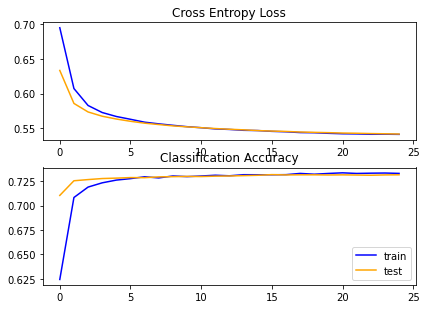

fold time:  0:01:28.622205
Fold 1
Test Index Start:40000
Test Set Size:40000


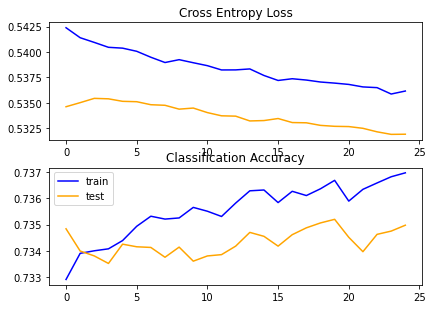

fold time:  0:01:32.170163
Fold 2
Test Index Start:80000
Test Set Size:40000


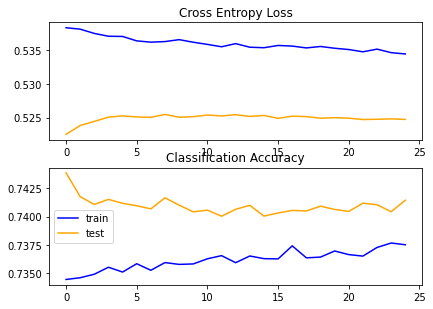

fold time:  0:01:30.157432
Fold 3
Test Index Start:120000
Test Set Size:40000


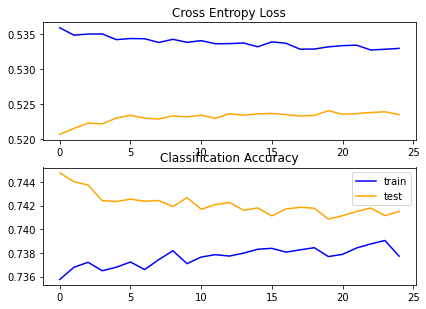

fold time:  0:01:32.955836
Fold 4
Test Index Start:160000
Test Set Size:40000


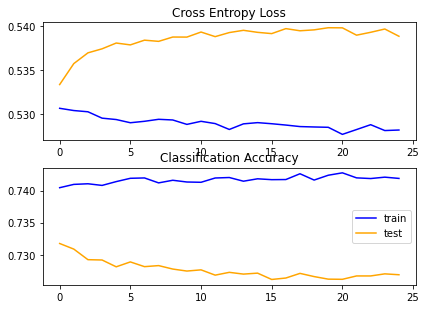

fold time:  0:01:35.253310


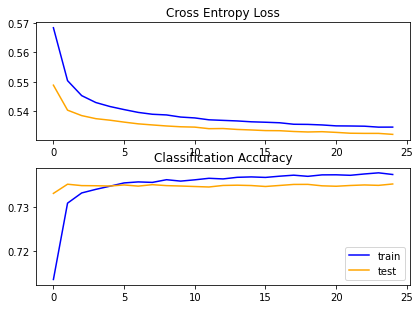

0:01:31.831789


In [7]:
# Create bag of words featureset for stemmed 
cv=CountVectorizer(max_features=500)
X=cv.fit_transform(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join)).toarray()
neg_tweets_stem = np.array([X[i] for i in range(len(y)) if y[i]==0 and any(X[i])])[:200000]
pos_tweets_stem = np.array([X[i] for i in range(len(y)) if y[i]==1 and any(X[i])])[:200000]
print(len(neg_tweets_stem), len(pos_tweets_stem))
kfold(model, neg_tweets_stem, pos_tweets_stem, 256)

In [ ]:
cv=CountVectorizer(max_features=1000)
X=cv.fit_transform().toarray()
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])[:200000]
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])[:200000]
print(len(neg_tweets_lemm), len(pos_tweets_lemm))
kfold(model, neg_tweets_lemm, pos_tweets_lemm, 256)

In [4]:
# Create model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4, 6, padding="same", activation="relu", input_shape=(140, 1)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='softmax'),

])

# Compile model
model.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)
model.summary()

t = tf.keras.preprocessing.text.Tokenizer(num_words = 140)
t.fit_on_texts(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join))
X = t.texts_to_matrix(processed_df['word_tokens_no_stop_stemmed'].apply(' '.join), mode="tfidf")
neg_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==0])
pos_tweets_lemm = np.array([X[i] for i in range(len(y)) if y[i]==1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 140, 4)            28        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 70, 4)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 280)               0         
                                                                 
 dense (Dense)               (None, 8)                 2248      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                        

In [1]:
kfold(model, neg_tweets_lemm[:400000], pos_tweets_lemm[:400000], 64)

NameError: name 'kfold' is not defined